In [2]:
# imports   
import torch
import gymnasium

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

from sklearn.tree import DecisionTreeClassifier

In [3]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

print(device)

mps


In [4]:
# plot methods 
def plot_scores(scores, env_name, avg_over, show_result=False):
    plt.figure(1)
    scores_t = torch.tensor(scores, dtype=torch.float)

    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')

    plt.xlabel('Episode')
    plt.ylabel('Duration' if env_name == 'CartPole-v1' else 'Reward')

    plt.plot(scores_t.numpy())

    # Take 100 episode averages and plot them too
    T = avg_over
    if len(scores_t) >= T:
        means = scores_t.unfold(0, T, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(T-1), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def plot_scores_compare(scores_list, colors, legend, avg_over, env_name):
    plt.figure(1)

    plt.title(f'Learning Curves ({env_name})')
    plt.xlabel('Episode')
    plt.ylabel('Duration' if env_name == 'CartPole-v1' else 'Reward')

    T = avg_over

    for i, scores in enumerate(scores_list):
        scores_t = torch.tensor(scores, dtype=torch.float)

        if len(scores_t) >= T:
            means = scores_t.unfold(0, T, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(T-1), means))
            plt.plot(means.numpy(), color=colors[i])

    plt.legend(legend)

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.display(plt.gcf())

In [7]:
# PPO Implementation
class PPO_Agent(nn.Module):
    def __init__(self, env):
        super(PPO_Agent, self).__init__()

        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n

        # Hyperparameters
        self.learning_rate = 0.0005
        self.gamma         = 0.98
        self.lmbda         = 0.95
        self.eps_clip      = 0.1
        self.K_epoch       = 3
        self.T_horizon     = 20

        self.data = []

        self.fc1   = nn.Linear(self.state_dim, 256)
        self.fc_pi = nn.Linear(256, self.action_dim)
        self.fc_v  = nn.Linear(256,1)
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        self.mseLoss = nn.MSELoss()

        self.scores = []

    
    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob

    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v

    def put_data(self, transition):
        self.data.append(transition)

    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition

            s_lst.append(s)
            a_lst.append(a)
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append(prob_a)
            done_lst.append([int(done)])

        s,a,r,s_prime,done, prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                          torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
                                          torch.tensor(done_lst, dtype=torch.float), torch.tensor(prob_a_lst)
        self.data = []
        return s, a, r, s_prime, done, prob_a

    def optimize_model(self):
        s, a, r, s_prime, done, prob_a = self.make_batch()

        rewards = []
        discounted_r = 0
        for reward, d in zip(reversed(r), reversed(done)):
            if d:
                discounted_r = 0
            discounted_r = reward + self.gamma * discounted_r
            rewards.insert(0, discounted_r)  # insert in front, cannot use append

        rewards = torch.tensor(rewards, dtype=torch.float32)
        if rewards.shape[0]>1:  # a batch with size 1 will cause 0 std
            rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        rewards = rewards

        for _ in range(self.K_epoch):
            vs = self.v(s)
            advantage = rewards - vs.squeeze(dim=-1).detach()
            vs_target = rewards

            pi = self.pi(s, softmax_dim=-1)
            dist = Categorical(pi)
            dist_entropy = dist.entropy()
            log_p = dist.log_prob(a)
            ratio = torch.exp(log_p - torch.log(prob_a))  # a/b == exp(log(a)-log(b))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-self.eps_clip, 1+self.eps_clip) * advantage
            # loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s) , vs_target.detach()) - 0.01*dist_entropy
            loss = -torch.min(surr1, surr2) + 0.5*self.mseLoss(vs.squeeze(dim=-1) , vs_target.detach()) - 0.01*dist_entropy

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

    def train_main(self):

      score = 0.0
      self.scores.clear()
      print_interval = 20

      num_episodes = 50
      if torch.cuda.is_available() or torch.backends.mps.is_available():
        num_episodes = 600

      for i_episode in range(num_episodes):
          s, _ = self.env.reset()
          cum_reward = 0
          done = False

          for t in count():

              prob = self.pi(torch.from_numpy(s).float())
              m = Categorical(prob)
              a = m.sample().item()
              s_prime, r, term, trunc, info = self.env.step(a)
              # env.render()

              cum_reward += r

              self.put_data((s, a, r/100.0, s_prime, prob[a].item(), term))

              s = s_prime

              score += r
              if term or trunc:
                  break

          self.optimize_model()


          self.scores.append(
              (t+1) if self.env.spec.id == 'CartPole-v1' else
              cum_reward
          )

          if i_episode%20==0:
            plot_scores(self.scores, self.env.spec.id, avg_over=100)


      plot_scores(self.scores, self.env.spec.id, show_result=True, avg_over=100)
      plt.ioff()
      plt.show()




### Training PPO (Deep Learning baseline) on Acrobat env

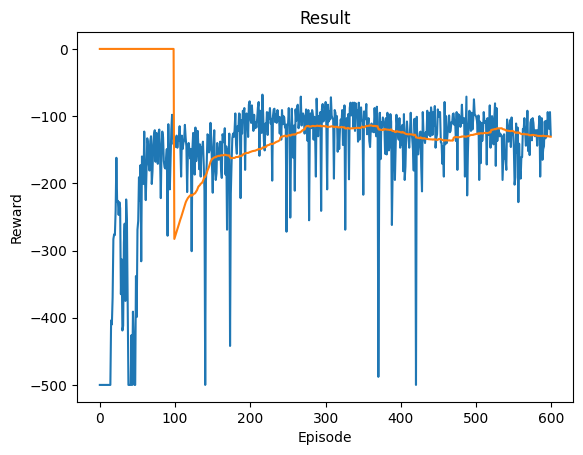

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
# train PPO on Acrobat environment
env  = gymnasium.make("Acrobot-v1")

PPO_agent = PPO_Agent(env)

PPO_agent.train_main()

In [14]:
# Implementing some useful functions
def get_action_func(policy):

    policy_str = str(policy)

    if policy_str.startswith('PPO_Agent'):
        def __get_action_ppo(s: np.ndarray):
            a = policy.pi(torch.from_numpy(s)).argmax(0)
            return a.detach().numpy()
        
        return __get_action_ppo
    
    elif policy_str.startswith('DecisionTree'):
        def __get_action_tree(s: np.ndarray):
            a = policy.predict(np.expand_dims(s, 0))
            return a[0]
        
        return __get_action_tree

    elif policy_str == 'uniform_random':
        def __get_action_uniform_random(s: np.ndarray):
            a = np.random.randint(0, 3, size=1)
            return a[0]
        
        return __get_action_uniform_random


        
def epsilon_greedy(action_func, eps):

    def __epsilon_greedy_action_func(s: np.ndarray):
    
        explore = (np.random.binomial(1, eps, 1)[0] == 1)

        if explore:
            uni_rand_action_func = get_action_func('uniform_random')
            return uni_rand_action_func(s)
        else:
            return action_func(s)

    return __epsilon_greedy_action_func


def collect_trajectories(env, action_func, N_EPI):
    trajectories = []
    
    for _ in range(N_EPI):
        trajectory = []
        
        s, _ = env.reset()

        while True:
            a = action_func(s)
            ns, reward, terminated, truncated, _ = env.step(a)
            trajectory.append(
                (s, a, ns, reward)
            )
            s = ns

            if terminated or truncated:
                break
        
        trajectories.append(trajectory)
    
    return trajectories


def run_policies(policies, env):
    # runs the policies on env for a few episodes
    # and returns the cumulative reward for each episode.

    ss = []

    for p in policies:

        action_func = get_action_func(p)
        tjs = collect_trajectories(env, action_func, N_EPI=100)
        scores = []

        for tj in tjs:
            cum_reward = sum(step[3] for step in tj)
            scores.append(cum_reward)

        ss.append(scores)

    return ss

In [15]:
# Implementation of the main algorithm
def distill_dt(expert_policy, env, M):

    X = []
    y = []
    learned_policies = []
    expert_action_func = get_action_func(expert_policy)

    # current_policy = 'uniform_random'
    current_policy = expert_policy

    for i in range(M):

        action_func = get_action_func(current_policy)
        action_func = epsilon_greedy(action_func, eps=0.5) # explore 50% time

        tjs = collect_trajectories(env, action_func, 20)

        for tj in tjs:
            for step in tj:
                X.append(step[0])
                expert_action = expert_action_func(step[0]) if i>0 else step[1]
                y.append(expert_action)

        current_policy = DecisionTreeClassifier(max_depth=10).fit(
            np.array(X), np.array(y)
        )
        learned_policies.append(current_policy)

    return learned_policies, X, y

### Distill the DL policy (PPO) into Decision Tree

In [16]:
dt_policies, X, y = distill_dt(PPO_agent, env, M=5)

dt_policies

[DecisionTreeClassifier(max_depth=10),
 DecisionTreeClassifier(max_depth=10),
 DecisionTreeClassifier(max_depth=10),
 DecisionTreeClassifier(max_depth=10),
 DecisionTreeClassifier(max_depth=10)]

In [ ]:
# print(len(y))

# for dt in dt_policies:

#     score = dt.score(X, y)
#     print(score)

16621

In [17]:
scores_list = run_policies(
                policies=[PPO_agent, *dt_policies], 
                env=env
            )

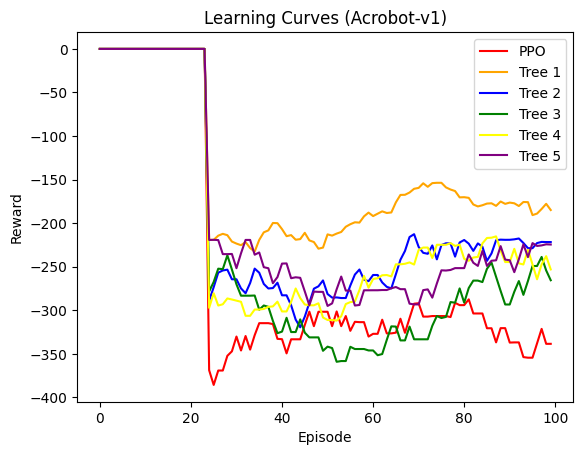

<Figure size 640x480 with 0 Axes>

In [19]:
plot_scores_compare(
    scores_list=scores_list,
    colors=['red', 'orange', 'blue', 'green', 'yellow', 'purple'],
    avg_over=25,
    legend=['PPO']+[f'Tree {i+1}' for i in range(5)], 
    env_name='Acrobot-v1'
)

### The best performing algorithm is the first decision tree (Tree 1).

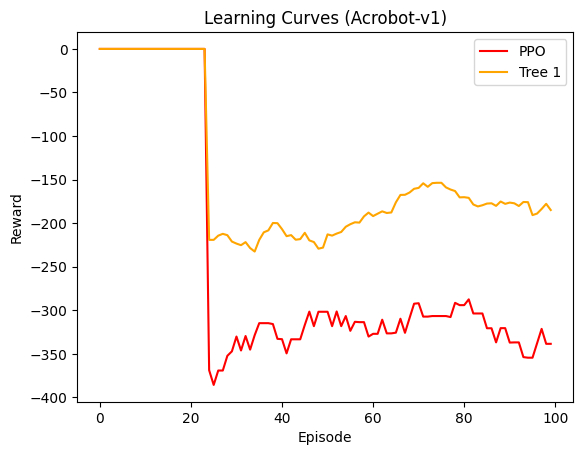

<Figure size 640x480 with 0 Axes>

In [20]:
plot_scores_compare(
    scores_list=scores_list[:2],
    colors=['red', 'orange'],
    avg_over=25,
    legend=['PPO']+['Tree 1'], 
    env_name='Acrobot-v1'
)

Conclusion: 
- Decision Tree is more stable and better performing
- I believe that Decison Tree is performing better than PPO because it is more regularized and PPO maybe learning from the noise as well. 
- And sicne Acrobat is a deterministic environment, the decision tree is able to represent the policy very well leading to better performance
